<a href="https://colab.research.google.com/github/onun1059/Resnet-18/blob/main/%EC%A2%85%EC%84%A4%20mid%20study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델에서 튜닝 가능한 하이퍼파라미터
* Convolutional layers: 필터의 갯수, 필터의 크기, stride값, zero-padding의 유무
* Pooling layers: Pooling방식 선택(MaxPool or AvgPool), Pool의 크기, Pool stride 값(overlapping)
* Fully-connected layers: 넓이(width)
* 활성함수(Activation function): ReLU(가장 주로 사용되는 함수), SoftMax(multi class classification), Sigmoid(binary classification)
* Loss function: Cross-entropy for classification, L1 or L2 for regression
* 최적화(Optimization) 알고리즘과 이것에 대한 hyperparameter(보통 learning rate): SGD(Stochastic gradient descent), SGD with momentum, AdaGrad, RMSprop
* Random initialization: Gaussian or uniform, Scaling
* https://halfundecided.medium.com/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-cnn-convolutional-neural-networks-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-836869f88375

* label smmothing
* https://paperswithcode.com/sota/image-classification-on-cifar-10
* efficient net/ resnet-19 / vggnet (세개 ensemble)
* https://untitledtblog.tistory.com/68   / overfitting
* valid : train에 참여하지 않는 학습이 안된 정보. 즉 test의 모의고사
* valid <-> train 하는 이유: 학습화된 정보에 대해서는 결과가 좋게 나오지만 학습이 안된 정보에 대해서는 올바르게 분류하지 못하므로, 즉 일반화된 추론이 되지 않는다.(generalize) -> overfitting
* overfitting 줄이는 방법(모델 변형, layer 증가, batchnormarl,dropout... etc)
* optimizer : SGD-> ADAM
* 모델 . training, loss. optimizer, transform, hyperparameter(마지막)
* 6. 이미지 전처리 부분 / 데이터 증강(data argumentation) 으로 학습량 증가. //train 부분만 건드릴것

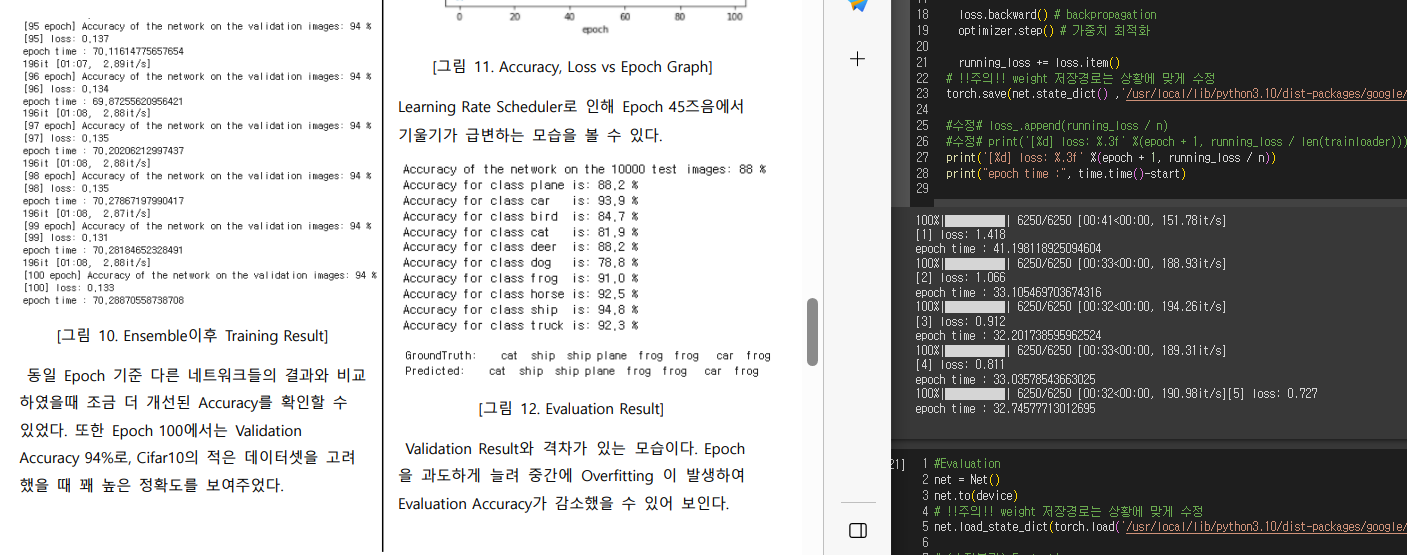

보고서의 좌측 화면에서 training set에서 epoch마다 나온 결과가 validation, 보고서의 우측화면에서 나온 accuracy와 총 정확동가 다른 것을 볼 수 있는데 이는 overfitting에 의한것
* 해야 할것: training set에서 실행마다 validation이 나오게 하여 epoch를 크게 하여 정확도와 비교 후 overfitting을 감소할 것

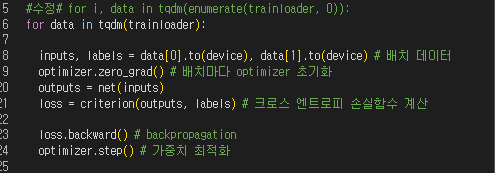

12. training /  먼저 pytorch는 자동 미분이 되어 있는데 optimizer.zero_grad()로 모든 미분값을 0으로 만든후 loss=criterion()으로 오차를 구한 후 loss.backward()로 모든 parameter에 대해 편 미분을 해 training 함수에 대한 학습의 방향을 정한다. 이로 인해 training 오차 그래프의 극솟값을 도출한다.
* lr=learning rate(학습량)/는 training에서 모든 편미분이 구해진후 극솟값에 가까워지는 x값과 비슷하다. 이때 극솟값에 쉽게 도출하기 위해 극솟값에 가까워지게 만든다(learning rate scheduler).  또한 최솟값이 아닌 극솟값에 갇혀 있을 수 있으므로 탈출하게 하는 값도 만들어야 한다.(global minima/ local minima)
* 사전에 학습했던 그래프 개형에 맞춰 관성을 갖게 움직이게 할 수 도 있다.

In [ ]:
# 1. 구글드라이브와 colab 연동  -결과 71퍼
from google.colab import drive  # 구글드라이브와 연동하기 위한 라이브러리
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 2. 라이브러리 import
# '''
# pytorch, torchvision, matplotlib, numpy, tqdm, time 라이브러리가 요구된다.
# '''

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [ ]:
# 3. 하이퍼 파라미터 설정
EPOCH = 150
batch_size = 128
learning_rate = .1
momentum = 0.9

In [ ]:
# 4. torch에서 사용할 gpu 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [ ]:
# 5. Classification할 Class list 지정
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# 6. 이미지 전처리
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
    )

In [ ]:
# 7. (수정불필요) Dataset 저장 및 Tensor 형태로 변환

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13223463.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from torch.utils.data import random_split

In [ ]:
# 모의 test 시 train_ration에 0.99 할당 / test 시 valid 필요 x-> train_ratio 1
train_ratio = 1
train_size = int(len(trainset) * train_ratio)
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])
print(len(trainset), len(validset))

50000 0


In [ ]:
# 모의 test시 validloader #제거
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # 출력: [batch_size, 512, 4, 4]
        out = F.avg_pool2d(out, 4) # 출력: [batch_size, 512, 1, 1]
        out = out.view(out.size(0), -1) # 출력: [batch_size, 512]
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# 9. Network 선언 및 device 위에 올리기
from torchsummary import summary
net = ResNet18().to(device)
summary(net, (3, 32, 32), batch_size=batch_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 32, 32]           1,728
       BatchNorm2d-2          [128, 64, 32, 32]             128
            Conv2d-3          [128, 64, 32, 32]          36,864
       BatchNorm2d-4          [128, 64, 32, 32]             128
            Conv2d-5          [128, 64, 32, 32]          36,864
       BatchNorm2d-6          [128, 64, 32, 32]             128
        BasicBlock-7          [128, 64, 32, 32]               0
            Conv2d-8          [128, 64, 32, 32]          36,864
       BatchNorm2d-9          [128, 64, 32, 32]             128
           Conv2d-10          [128, 64, 32, 32]          36,864
      BatchNorm2d-11          [128, 64, 32, 32]             128
       BasicBlock-12          [128, 64, 32, 32]               0
           Conv2d-13         [128, 128, 16, 16]          73,728
      BatchNorm2d-14         [128, 128,

In [ ]:
def adjust_learning_rate(optimizer, epoch):   # learning_rate scheduler
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def evaluate(model, dataloader, criterion):
    with torch.no_grad():
        model.eval()
        n_total, n_correct = 0, 0
        running_loss = 0.0
        for img, labels in dataloader:
            out = model(img.to(device))
            _, y_pred = torch.max(out.data, 1)
            n_correct += (y_pred==labels.to(device)).sum().item()
            n_total += img.size(0)
            running_loss += criterion(out, labels.to(device)).item()
        val_acc = n_correct/n_total
    return val_acc, running_loss/len(dataloader)


In [ ]:
import numpy as np

mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, y, targets, smoothing=0.1):
        confidence = 1. - smoothing
        log_probs = F.log_softmax(y, dim=-1) # 예측 확률 계산
        true_probs = torch.zeros_like(log_probs)
        true_probs.fill_(smoothing / (y.shape[1] - 1))
        # 정답 인덱스의 정답 확률을 confidence로 변경
        true_probs.scatter_(1, targets.data.unsqueeze(1), confidence)
        # negative log likelihood
        return torch.mean(torch.sum(true_probs * -log_probs, dim=-1))

In [ ]:
net = ResNet18()
net = net.to(device)

# 이전 기록에서 이어서 학습을 원하면 주석을 해제할 것.
#net.load_state_dict(torch.load('/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'))

learning_rate = 0.1

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(net.parameters(),
            lr=learning_rate, momentum=0.9, weight_decay=0.0002)


In [ ]:
# 12. Training

train_losses = []
valid_losses = []
accuracies = []

n = len(trainloader)

for epoch in range(EPOCH):
  adjust_learning_rate(optimizer, epoch)
  running_loss = 0.0
  start = time.time()


  for data in tqdm(trainloader):

    inputs, targets = data[0].to(device), data[1].to(device) # 배치 데이터
    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)

    optimizer.zero_grad() # 배치마다 optimizer 초기화
    outputs = net(inputs)

    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
    # Trainging-크로스 엔트로피 손실함수 계산

    loss.backward() # backpropagation
    # import pdb; pdb.set_trace()
    optimizer.step() # 가중치 최적화

    running_loss += loss.item()

# valid 모의 test시 실행
#   valid_acc, valid_loss = evaluate(net, validloader, criterion)
  train_loss = running_loss / n
  train_losses.append(train_loss)
#   valid_losses.append(valid_loss)
#   accuracies.append(valid_acc)
  torch.save(net.state_dict() ,'/usr/local/lib/python3.10/dist-packages/google/colab/drive.py')

  #수정# loss_.append(running_loss / n)
  #수정# print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))
  print("epoch time :", time.time()-start)
#   print("valid accuracy : ", round다음(accuracies[-1], 3))


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[1] loss: 1.986
epoch time : 57.71519923210144


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[2] loss: 1.902
epoch time : 58.03794884681702


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[3] loss: 1.818
epoch time : 57.87635517120361


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[4] loss: 1.756
epoch time : 57.704121828079224


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[5] loss: 1.700
epoch time : 57.38904690742493


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[6] loss: 1.664
epoch time : 57.573423862457275


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[7] loss: 1.614
epoch time : 57.89595913887024


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[8] loss: 1.564
epoch time : 57.61160492897034


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[9] loss: 1.546
epoch time : 57.7501859664917


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[10] loss: 1.526
epoch time : 57.79736948013306


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[11] loss: 1.495
epoch time : 57.78942942619324


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


[12] loss: 1.492
epoch time : 58.177796602249146


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[13] loss: 1.501
epoch time : 57.7982280254364


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[14] loss: 1.455
epoch time : 57.84401607513428


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[15] loss: 1.459
epoch time : 57.88565516471863


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[16] loss: 1.455
epoch time : 57.72619962692261


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[17] loss: 1.424
epoch time : 57.88642334938049


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[18] loss: 1.413
epoch time : 57.590696573257446


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[19] loss: 1.421
epoch time : 57.75757193565369


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[20] loss: 1.412
epoch time : 57.65160608291626


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


[21] loss: 1.415
epoch time : 58.132219076156616


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[22] loss: 1.404
epoch time : 57.524736404418945


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[23] loss: 1.387
epoch time : 57.85790657997131


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[24] loss: 1.404
epoch time : 57.408023834228516


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[25] loss: 1.375
epoch time : 57.420960426330566


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[26] loss: 1.384
epoch time : 57.53463172912598


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[27] loss: 1.387
epoch time : 57.51634931564331


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


[28] loss: 1.370
epoch time : 57.13277292251587


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[29] loss: 1.369
epoch time : 57.34778881072998


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[30] loss: 1.376
epoch time : 57.38264775276184


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[31] loss: 1.381
epoch time : 57.8588650226593


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[32] loss: 1.376
epoch time : 57.45599174499512


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[33] loss: 1.353
epoch time : 57.37840533256531


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[34] loss: 1.365
epoch time : 57.515031576156616


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[35] loss: 1.350
epoch time : 57.20293569564819


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[36] loss: 1.352
epoch time : 57.79277062416077


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[37] loss: 1.363
epoch time : 57.20301842689514


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[38] loss: 1.373
epoch time : 57.33633065223694


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[39] loss: 1.355
epoch time : 57.16306114196777


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[40] loss: 1.353
epoch time : 57.49799942970276


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[41] loss: 1.329
epoch time : 57.84203743934631


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[42] loss: 1.353
epoch time : 57.4385507106781


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[43] loss: 1.332
epoch time : 57.15156555175781


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[44] loss: 1.328
epoch time : 57.51372313499451


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[45] loss: 1.342
epoch time : 57.25252437591553


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[46] loss: 1.313
epoch time : 57.897597551345825


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[47] loss: 1.323
epoch time : 57.28855276107788


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[48] loss: 1.329
epoch time : 57.505605936050415


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[49] loss: 1.362
epoch time : 57.26128602027893


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[50] loss: 1.319
epoch time : 57.48993468284607


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[51] loss: 1.273
epoch time : 57.50963044166565


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[52] loss: 1.232
epoch time : 57.463484048843384


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[53] loss: 1.213
epoch time : 57.2528121471405


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[54] loss: 1.212
epoch time : 57.404587507247925


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[55] loss: 1.225
epoch time : 57.201751470565796


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[56] loss: 1.203
epoch time : 57.73709964752197


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[57] loss: 1.227
epoch time : 57.30362868309021


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[58] loss: 1.198
epoch time : 57.42168068885803


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


[59] loss: 1.196
epoch time : 57.12866473197937


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[60] loss: 1.217
epoch time : 57.46243166923523


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[61] loss: 1.197
epoch time : 57.533411741256714


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[62] loss: 1.210
epoch time : 57.88949632644653


100%|██████████| 391/391 [00:56<00:00,  6.86it/s]


[63] loss: 1.201
epoch time : 57.058778047561646


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[64] loss: 1.182
epoch time : 57.4150173664093


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[65] loss: 1.194
epoch time : 57.67539095878601


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[66] loss: 1.194
epoch time : 57.248138666152954


100%|██████████| 391/391 [00:56<00:00,  6.90it/s]


[67] loss: 1.183
epoch time : 56.72989201545715


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[68] loss: 1.180
epoch time : 57.22324776649475


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


[69] loss: 1.166
epoch time : 56.87741208076477


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[70] loss: 1.187
epoch time : 57.50733733177185


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[71] loss: 1.180
epoch time : 57.241448402404785


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


[72] loss: 1.177
epoch time : 57.11456799507141


100%|██████████| 391/391 [00:56<00:00,  6.89it/s]


[73] loss: 1.210
epoch time : 56.91833424568176


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[74] loss: 1.181
epoch time : 57.34581136703491


100%|██████████| 391/391 [00:57<00:00,  6.84it/s]


[75] loss: 1.167
epoch time : 57.33465600013733


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


[76] loss: 1.186
epoch time : 56.92218565940857


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


[77] loss: 1.161
epoch time : 56.99292778968811


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


[78] loss: 1.187
epoch time : 57.03222370147705


100%|██████████| 391/391 [00:56<00:00,  6.87it/s]


[79] loss: 1.191
epoch time : 57.046411991119385


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[80] loss: 1.175
epoch time : 57.31269431114197


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[81] loss: 1.158
epoch time : 57.476991415023804


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[82] loss: 1.177
epoch time : 57.75069284439087


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[83] loss: 1.166
epoch time : 57.802950382232666


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[84] loss: 1.176
epoch time : 57.935972929000854


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


[85] loss: 1.149
epoch time : 58.116037130355835


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[86] loss: 1.182
epoch time : 57.53886938095093


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[87] loss: 1.187
epoch time : 57.86068630218506


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[88] loss: 1.167
epoch time : 57.67216205596924


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[89] loss: 1.188
epoch time : 58.04661536216736


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[90] loss: 1.183
epoch time : 58.005210638046265


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[91] loss: 1.168
epoch time : 57.842241525650024


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[92] loss: 1.177
epoch time : 57.47466063499451


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


[93] loss: 1.185
epoch time : 58.16540217399597


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[94] loss: 1.132
epoch time : 57.64349913597107


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


[95] loss: 1.156
epoch time : 58.34427499771118


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[96] loss: 1.172
epoch time : 57.87693476676941


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[97] loss: 1.176
epoch time : 58.02769589424133


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[98] loss: 1.171
epoch time : 58.002591371536255


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[99] loss: 1.140
epoch time : 57.86617136001587


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[100] loss: 1.154
epoch time : 57.91235566139221


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[101] loss: 1.146
epoch time : 57.610838174819946


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[102] loss: 1.155
epoch time : 57.848541498184204


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[103] loss: 1.148
epoch time : 57.55935621261597


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


[104] loss: 1.119
epoch time : 58.290621757507324


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[105] loss: 1.124
epoch time : 57.64090013504028


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[106] loss: 1.126
epoch time : 57.86935567855835


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[107] loss: 1.124
epoch time : 57.42303490638733


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[108] loss: 1.158
epoch time : 57.91472554206848


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


[109] loss: 1.133
epoch time : 58.19375562667847


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[110] loss: 1.125
epoch time : 57.75152778625488


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[111] loss: 1.118
epoch time : 57.85843229293823


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[112] loss: 1.139
epoch time : 57.552231550216675


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[113] loss: 1.127
epoch time : 57.93993854522705


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[114] loss: 1.128
epoch time : 57.7888867855072


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[115] loss: 1.131
epoch time : 57.850505113601685


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[116] loss: 1.136
epoch time : 57.5783154964447


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[117] loss: 1.125
epoch time : 58.07212209701538


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[118] loss: 1.147
epoch time : 58.02711606025696


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[119] loss: 1.113
epoch time : 57.85276699066162


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[120] loss: 1.140
epoch time : 57.67400002479553


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


[121] loss: 1.139
epoch time : 57.99258303642273


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[122] loss: 1.126
epoch time : 57.67033338546753


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


[123] loss: 1.123
epoch time : 58.285940170288086


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[124] loss: 1.127
epoch time : 57.84909749031067


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[125] loss: 1.129
epoch time : 57.833940744400024


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[126] loss: 1.111
epoch time : 57.87503790855408


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


[127] loss: 1.121
epoch time : 57.79145431518555


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[128] loss: 1.131
epoch time : 57.96641254425049


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


[129] loss: 1.132
epoch time : 57.82031297683716


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[130] loss: 1.104
epoch time : 57.7228729724884


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[131] loss: 1.119
epoch time : 57.2223436832428


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[132] loss: 1.122
epoch time : 57.55276012420654


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[133] loss: 1.123
epoch time : 57.33675527572632


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[134] loss: 1.099
epoch time : 57.56560754776001


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


[135] loss: 1.103
epoch time : 57.17003560066223


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[136] loss: 1.123
epoch time : 57.567211627960205


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[137] loss: 1.131
epoch time : 57.72575521469116


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[138] loss: 1.120
epoch time : 57.9604606628418


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


[139] loss: 1.128
epoch time : 57.384488582611084


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]


[140] loss: 1.116
epoch time : 57.45218276977539


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


[141] loss: 1.132
epoch time : 57.53703284263611


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


[142] loss: 1.123
epoch time : 58.43689823150635


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[143] loss: 1.108
epoch time : 57.71250605583191


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[144] loss: 1.106
epoch time : 57.63065266609192


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


[145] loss: 1.131
epoch time : 57.707040786743164


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[146] loss: 1.113
epoch time : 57.966676235198975


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


[147] loss: 1.121
epoch time : 58.11488914489746


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


[148] loss: 1.134
epoch time : 57.58791899681091


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


[149] loss: 1.112
epoch time : 57.96582102775574


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]

[150] loss: 1.130
epoch time : 57.588226556777954


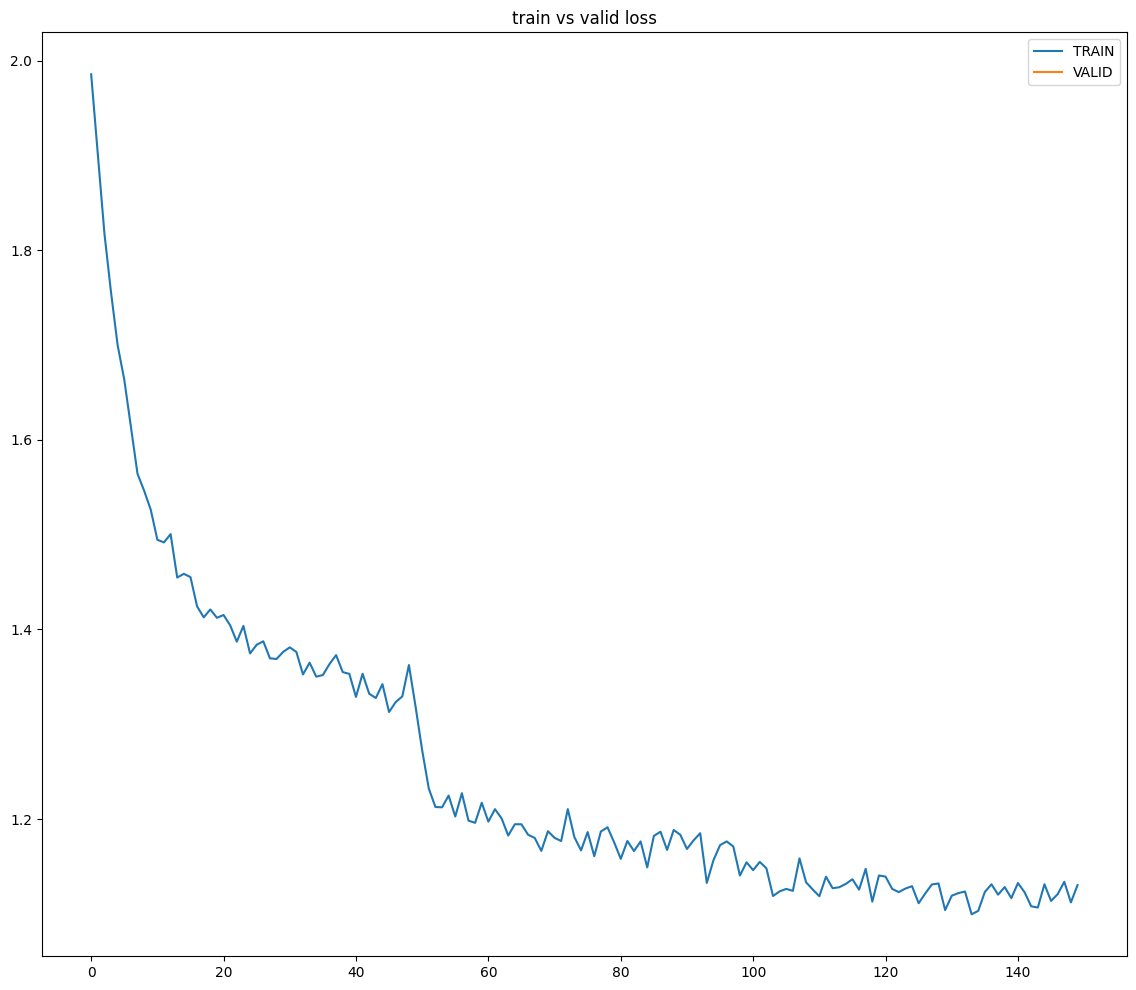

In [ ]:
plt.figure(figsize=(14,12))
plt.title("train vs valid loss")
plt.plot(train_losses, label="TRAIN")
plt.plot(valid_losses, label="VALID")
plt.legend()
plt.show()

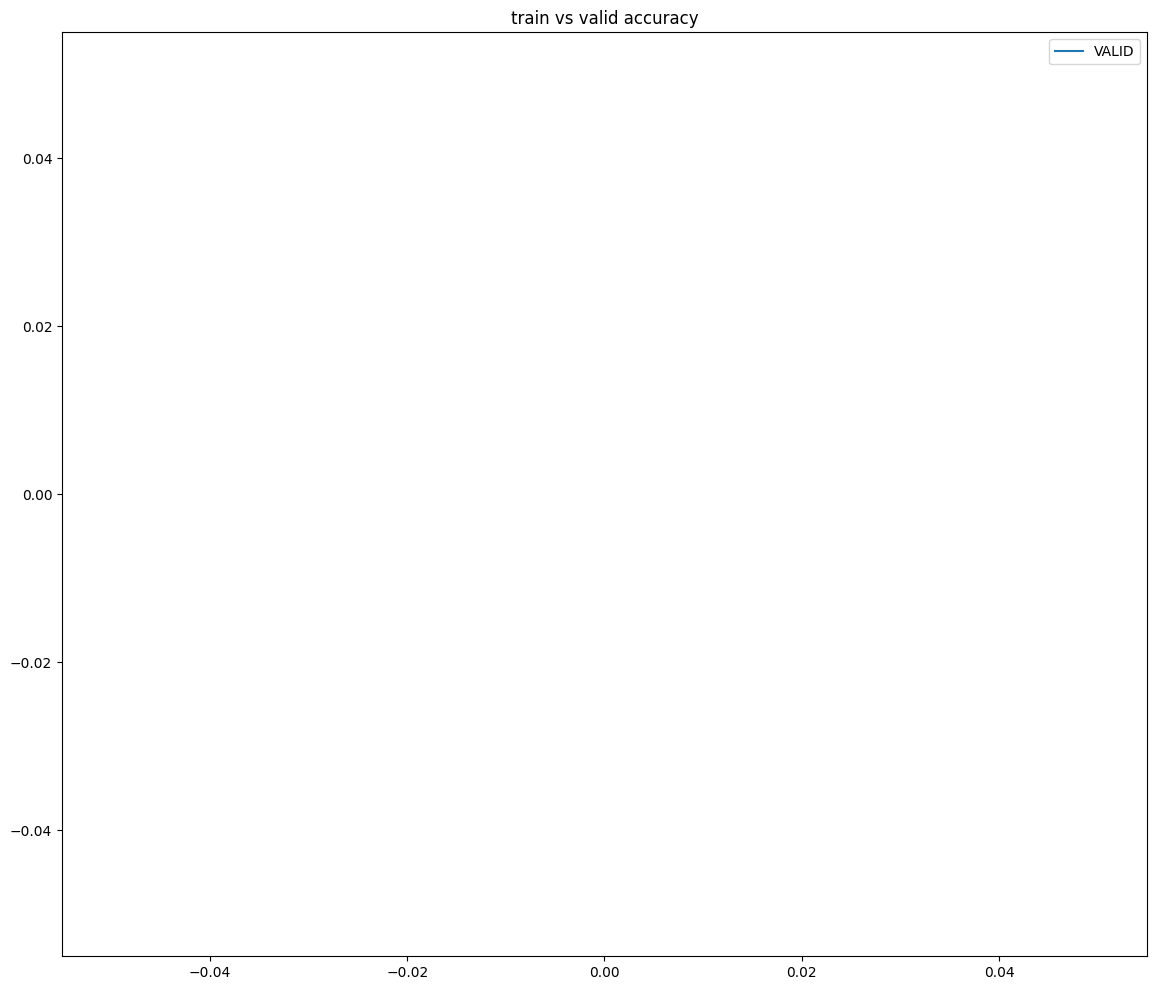

In [ ]:
plt.figure(figsize=(14,12))
plt.title("train vs valid accuracy")
plt.plot(accuracies, label="VALID")
plt.legend()
plt.show()

In [ ]:
# Evaluation
net = ResNet18()
net.to(device)
# !!주의!! weight 저장경로는 상황에 맞게 수정
net.load_state_dict(torch.load('/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'))

# (수정불가) Evaluation
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}  #dictionary 생성
total_pred = {classname: 0 for classname in classes}    #dictionary 생성

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad(): # autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높일 수 있다.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # labels.size = batch_size
        correct += (predicted == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the 10000 test images: 94 %
Accuracy for class plane is: 95.8 %
Accuracy for class car   is: 98.5 %
Accuracy for class bird  is: 92.5 %
Accuracy for class cat   is: 89.5 %
Accuracy for class deer  is: 95.3 %
Accuracy for class dog   is: 90.6 %
Accuracy for class frog  is: 96.7 %
Accuracy for class horse is: 97.3 %
Accuracy for class ship  is: 97.3 %
Accuracy for class truck is: 96.0 %


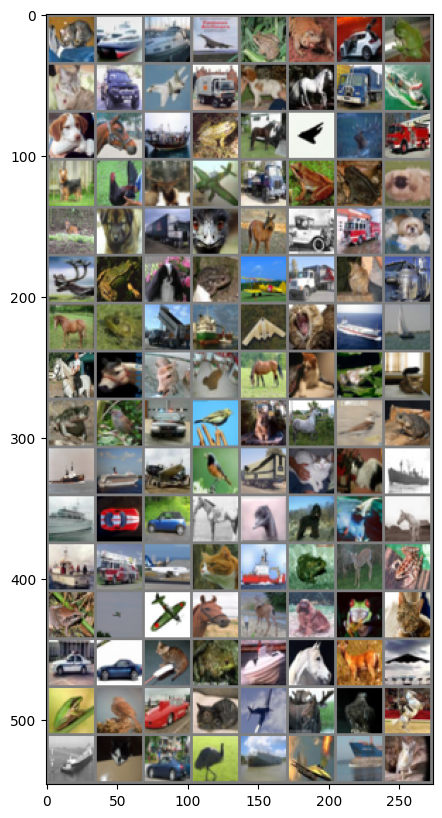

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:  horse   dog  ship plane  ship  deer horse plane


In [ ]:
#Inference
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
#수정# images, labels = dataiter.next()
images, labels = next(dataiter)

# GroundTruth display
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

# Predicted display
net = ResNet18()
net.to(device)
# !!주의!! weight 저장경로는 상황에 맞게 수정
net.load_state_dict(torch.load('/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))